<a href="https://colab.research.google.com/github/ameyshinde28/LearningPytorch/blob/main/06_pytorch_transfer_learning_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning

What is Transfer Learning?

Transfer Learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem.

* Pretrained model = fundation models

In [ ]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


Now we've got the versions of torch and torchvision, we've after, let's import the code we've written in previous sections so that we don't have to write it

In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 23.26 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get Data
We need our pizza, steak, sushi data to build a transfer learning model on.

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists, skipping re-download.")
else:
  print(f"Did not find { image_path}, downloading it ...")
  image_path.mkdir(parents=True, exist_ok = True)

  # Download pizza, steak, sushi data....
  with open(data_path / "pizza_steak_sushi.zip", "wb")as f:
    request =requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)


  # Unzip pizza, steak , sushi data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unizipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # Remove .zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi, downloading it ...
Unizipping pizza, steak, sushi data...


In [ ]:
# Setup data directory
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Dataseta and DataLoaders
Now we've got some data, want to turn it into PyTorch DataLoaders.
use `data_setup.py` and the `create_dataloaders()` function .

There's one thing we have to think about when loading: how to **transform** it ?

1. Manually created transforms - you define what transforms you want your data to go through.
2. Automatically created transforms.


Important point: When using a pretrained model, it's important that the data (including your custom data) that you oass through it is **transformed** in the same way the data the model was trained on.

In [ ]:
from going_modular.going_modular import data_setup

### 2.1 Creating a transform from `torchvision.models` (manual creation)


All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.

The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [ ]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [ ]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79f578492f50>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)
As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model

In [ ]:
import torchvision
torchvision.__version__


'0.17.1+cu121'

In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = Best available model
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms =weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Create DataLoader using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32
                                                                               )

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79f4645fb310>,
 ['pizza', 'steak', 'sushi'])

### 3.1 Which pretrained model should you use?

*Experiment, experiment, ezperiment!*

The whole idea of transfer learning: take an already well_performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:
1. Speed
2. Size
3. Performance

Looking at https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights

Which model should we choose?

For our case, it looks like EffNetB0
is one of our best option in terms performance vs size.

However, in light of The Bitter Lesson, if we had infinite, compute, we'd likely
pick the biggest model + most parameters + we could.

http://www.incompleteideas.net/IncIdeas/BitterLesson.html

### 3.2 Setting up a pretrained model
Want to create an instance of a pretrained EffNetB0-
https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html#efficientnet-b0
https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html#efficientnet-b0



In [ ]:
# Old method of creating a pretrained model
# model = torchvision.models.efficientnet_b0(pretrained=True)

# New method
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 41.9MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [ ]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [ ]:
!pip install torchinfo

In [ ]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), # batch size, color_channels , height, width
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs
With a feature extractor model , typically you will 'freeze' bse ;ayers of a pretrained/ foundation model and update the output layer to suit your own problem.

In [ ]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
  param.requires_grad = False
  # print(param)

In [ ]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names))
).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [ ]:
summary(model=model,
        input_size=(1, 3, 224, 224), # batch size, color_channels , height, width
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train Model

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Import train function
from going_modular.going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End time
end_time=timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f}seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
[INFO] Total training time: 223.243seconds


## 5. Evaluate model by plotting loss curve

[INFO] Couldn't find helper_functions.py, DOWNLOADING...


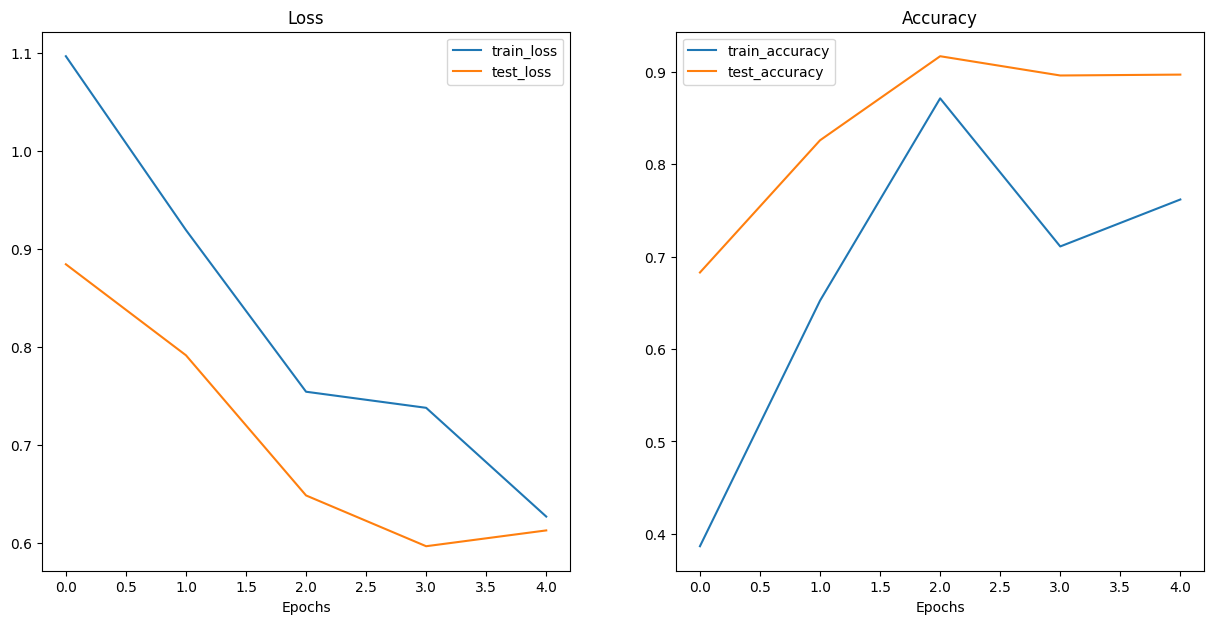

In [ ]:
try:
  from helper_function import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py, DOWNLOADING...")
  with open("helper_function.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)

  from helper_function import plot_loss_curves

plot_loss_curves(results)

What do our loss curves look like in terms of the ideal loss curves?

For more see here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

## 6. Make predictions on images from the test set

Let's adhere to the data explorer;s motto of * visualize,cisualize, visualize*!

And make some qualitative predictions/ inference on data/custom data.

We have to make sure that our test/custom data is:
* Same shape - imags need to be same shape as model was trained on
* Same datatype - custom data shoulf be  in the same data type
* Same device - custom data/test data should be on the same device as the model
* Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same

To do all of this automatically, let's create a function called `pred_and_plot_image()`:

THe function will be similar to the one here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

1. Take in a trained model , a list of class names, a filepath to a target image, an  image size a transform a target device
2. Open the image with `PIL.Image.Open()`
3. Make sure the model is on the target device
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimensionality is suited for the model(this mainly relates to batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probs using `torch.softmax()`
9. Convert the model's prediction probs to predictionlabels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction preobability from step 8.

In [ ]:
from typing import List, Tuple
from PIL import Image

import matplotlib.pyplot as plt


# 1. Take in a trained model...
def pred_and_plot_image(model: torch.nn.Module,
                        image_path:str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms =None,
                        device: torch.device=device):
  # 2. Open the image with PIL
  img = Image.open(image_path)

  # 3. Create a transorm if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
        ])

  ### Predict on image ###
  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform the image and add an extra batch dimension
    transformed_image = image_transform(img).unsqueeze(dim=0)

    #7, Make a predicrion on the transformed image by passing it ti the model(also)
    target_image_pred = model(transformed_image.to(device))

    # 8. Conver the model's output logits ti ored probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert the model's output pred probs to pred labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

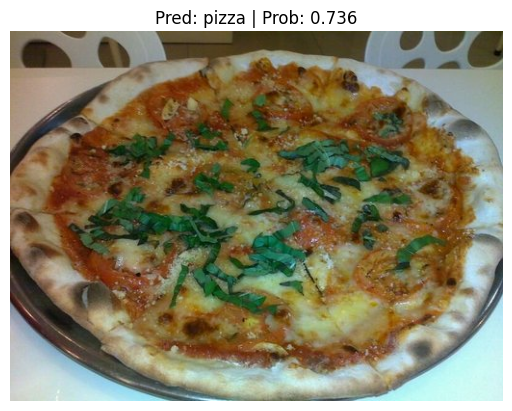

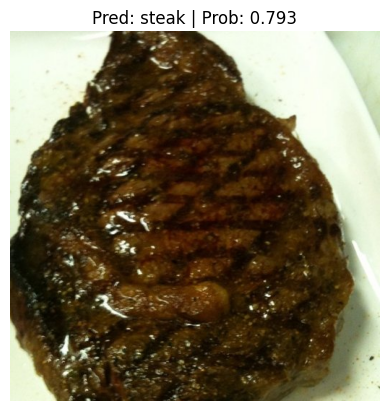

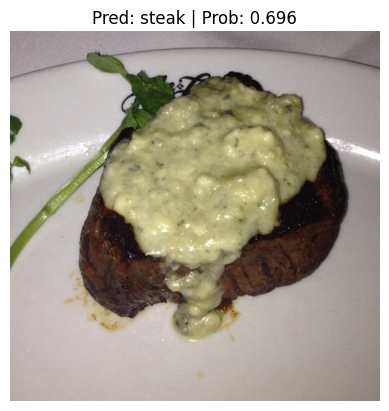

In [ ]:
# Get a random list of images path from the test set
import random
num_images_to_plot =3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)
# Make predictions and plot images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size= (224, 224))


### 6.1 Making prediction on a custom

In [ ]:
# Download the image
import requests

# Setup custom image path

custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Download {custom_image_path}")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")

Download data/04-pizza-dad.jpeg


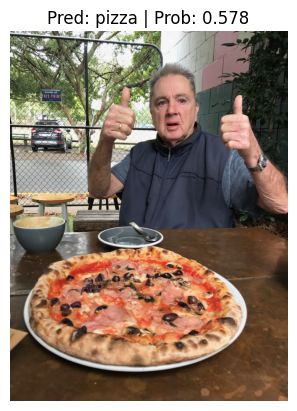

In [ ]:
# Pred on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)